In [235]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [236]:
import numpy as np
import pandas as pd

In [237]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [238]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [239]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [240]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [241]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [242]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [243]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [244]:
data_1 = engine.execute("SELECT * FROM Measurement") 
measurement_data = pd.read_sql("SELECT * FROM Measurement", conn)
measurement_data.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


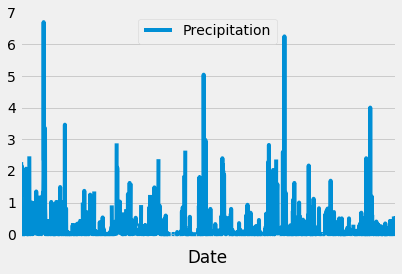

In [245]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_one_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_one_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = pd.DataFrame(precipitation_scores, columns=['Date','Precipitation'])
precipitation.set_index(precipitation['Date'], inplace=True)

# Sort the dataframe by date
precipitation = precipitation.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams["figure.figsize"] = (6,4)
precipitation.plot(x_compat=True)
#precipitation.xticks(rotation='45')
plt.xticks([])
#plt.tight_layout()
#plt.show()
plt.savefig('Precipitation_Plt.png')

In [246]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [260]:
# Design a query to show how many stations are available in this dataset?
stat_no=session.query(func.count(Station.station)).all()
stat_no

[(9)]

In [248]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_list = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
station_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [249]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

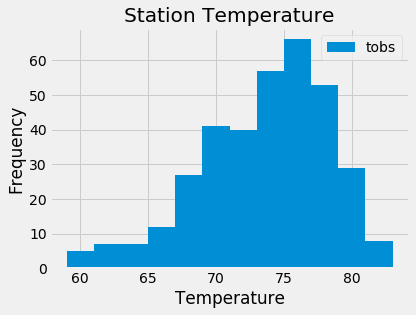

In [250]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_temp = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= last_one_year ).all()
station_result = pd.DataFrame(station_temp, columns=['tobs'])
station_result.plot.hist(bins=12)
plt.tight_layout()
plt.title ('Station Temperature')
plt.xlabel('Temperature')
plt.savefig('Station_Hist.png')

In [251]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [252]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

year_start = dt.date(2012, 2, 28) - dt.timedelta(days=365)
year_end = dt.date(2012, 3, 5) - dt.timedelta(days=365)

tmin,tave,tmax = calc_temps(year_start.strftime("%Y-%m-%d"), year_end.strftime("%Y-%m-%d"))[0]
print(tmin,tave,tmax)

61.0 70.08928571428571 75.0


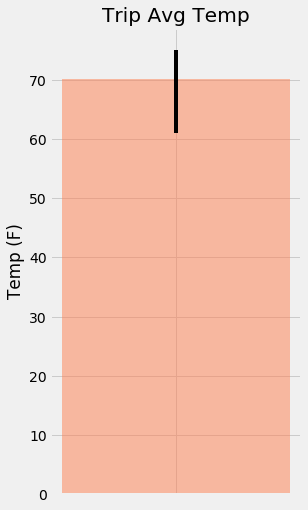

In [253]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lower_limit = tave - tmin
upper_limit = tmax - tave
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
ax.bar([0], [tave], yerr=[[lower_limit],[upper_limit]], alpha=0.5, color='coral', width=0.01, bottom=None)
plt.title('Trip Avg Temp')
plt.xticks([0], (''))
ax.set_ylabel("Temp (F)")
plt.savefig('Trip Avg Temp.png')
plt.show()


In [254]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2012-02-28'
end_date = '2012-03-05'

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

precipitation_results = session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(precipitation_results)

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 11.08), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 10.32), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.79), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 3.8400000000000003), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.92), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.1800000000000002), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.76), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.03), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]


## Optional Challenge Assignment

In [255]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [256]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2012-02-28'
end_date = '2012-03-05'
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date, freq='D')
# Stip off the year and save a list of %m-%d strings
month_day = trip_dates.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in month_day:
    normals.append(*daily_normals(date))
    
normals


[(65.0, 70.65517241379311, 80.0),
 (67.0, 71.73333333333333, 79.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [257]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
trip_df['Date'] = trip_dates
trip_df.set_index(['Date'],inplace=True)
trip_df

,tmin,tavg,tmax
Date,,,
2012-02-28,65.0,70.655172,80.0
2012-02-29,67.0,71.733333,79.0
2012-03-01,64.0,70.032787,76.0
2012-03-02,61.0,70.366667,78.0
2012-03-03,60.0,70.068966,78.0
2012-03-04,57.0,69.272727,77.0
2012-03-05,60.0,67.890909,76.0


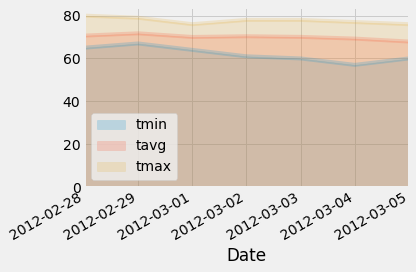

In [258]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True)
plt.tight_layout()
plt.rcParams["figure.figsize"] = (10,5)
plt.savefig("Daily Normal.png")
plt.show()
